In [1]:
import os
from env import host, user, password
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.neighbors import KNeighborsRegressor

from scipy import stats

import acquire as a
import prepare as p

pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Acquire

- Connect to SQL database using credentials
- Query the data to gather single-unit/single-family residences
- save as csv file
- convert to pandas dataframe for analysis

In [2]:
df = a.get_zillow_data()
a.summarize_stats(df)

YOU CAN'T HANDLE THE STATS!!!!!!
|------------------------------------------------------|
|------------------------------------------------------|
Shape: (72085, 68)
|------------------------------------------------------|
<class 'pandas.core.frame.DataFrame'>
Int64Index: 72085 entries, 0 to 72084
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            72085 non-null  int64  
 1   parcelid                      72085 non-null  int64  
 2   airconditioningtypeid         23023 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   72085 non-null  float64
 6   bedroomcnt                    72085 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         44951 non-null  float64
 9   calculatedbath

1252.00000    22
1462.00000    21
780.00000     21
1205.00000    21
1441.00000    21
              ..
2290.00000     1
640.00000      1
695.00000      1
2062.00000     1
3070.00000     1
Name: finishedsquarefeet50, Length: 1807, dtype: int64

[  nan 1465.  842. ... 5774.  943. 2652.]
|------------------------------------------------------|
|------------------------------------------------------|
|-------finishedsquarefeet6-------|

dtpye: float64

Null count: 71919

count    166.00000
mean    1235.96988
std      777.39281
min      380.00000
25%      769.75000
50%      998.50000
75%     1318.25000
max     5598.00000
Name: finishedsquarefeet6, dtype: float64

952.00000     4
520.00000     3
845.00000     2
765.00000     2
926.00000     2
             ..
1879.00000    1
595.00000     1
1445.00000    1
1056.00000    1
384.00000     1
Name: finishedsquarefeet6, Length: 156, dtype: int64

[  nan  750. 1132. 1235.  520.  908.  600. 2792. 1360.  856.  688.  634.
  938. 1012. 2030. 4086. 1517. 

count   14628.00000
mean        1.00000
std         0.00000
min         1.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         1.00000
Name: pooltypeid7, dtype: float64

1.00000    14628
Name: pooltypeid7, dtype: int64

[nan  1.]
|------------------------------------------------------|
|------------------------------------------------------|
|-------propertycountylandusecode-------|

dtpye: object

Null count: 0

count     72085
unique       44
top        0100
freq      26714
Name: propertycountylandusecode, dtype: object

0100    26714
122     13045
010C     8813
0101     6399
34       4922
1111     3353
1        2392
010E     2047
1129     1378
1110     1024
012C      384
0104      367
1128      333
01DC      211
01HC      137
010G       93
0103       91
010H       64
0108       57
1117       55
010M       52
0700       50
0109       18
01HE       11
1116       10
73          9
1112        8
0113        6
0110        6
070D        5
012E        5
0141        

100000.00000    70
90000.00000     51
200000.00000    48
95000.00000     46
104000.00000    41
                ..
129614.00000     1
151311.00000     1
78442.00000      1
454077.00000     1
896.00000        1
Name: structuretaxvaluedollarcnt, Length: 48234, dtype: int64

[485713.  88000.  85289. ...  70917.  32797.  77118.]
|------------------------------------------------------|
|------------------------------------------------------|
|-------taxvaluedollarcnt-------|

dtpye: float64

Null count: 1

count      72084.00000
mean      489885.58992
std       665044.25315
min         1000.00000
25%       204000.00000
50%       355737.50000
75%       566926.00000
max     49061236.00000
Name: taxvaluedollarcnt, dtype: float64

400000.00000     44
450000.00000     43
340000.00000     42
350000.00000     42
375000.00000     40
                 ..
217013.00000      1
368489.00000      1
124890.00000      1
1736092.00000     1
327680.00000      1
Name: taxvaluedollarcnt, Length: 48138, dtype: in

Name: propertylandusedesc, dtype: int64

['Single Family Residential' 'Condominium' 'Cluster Home'
 'Manufactured, Modular, Prefabricated Homes' 'Mobile Home' 'Townhouse']
|------------------------------------------------------|
|------------------------------------------------------|
|-------storydesc-------|

dtpye: object

Null count: 72035

count           50
unique           1
top       Basement
freq            50
Name: storydesc, dtype: object

Basement    50
Name: storydesc, dtype: int64

[nan 'Basement']
|------------------------------------------------------|
|------------------------------------------------------|
|-------typeconstructiondesc-------|

dtpye: object

Null count: 71863

count       222
unique        4
top       Frame
freq        219
Name: typeconstructiondesc, dtype: object

Frame       219
Concrete      1
Masonry       1
Metal         1
Name: typeconstructiondesc, dtype: int64

[nan 'Frame' 'Masonry' 'Metal' 'Concrete']
|---------------------------------------

**Acquire Takeaways**
- Start with 72085 rows
- Most columns have null values that will need to be addressed
- The datatype of some columns are objects
    - Most are int or float

---
## Prepare

1. Drop columns that are have more than 50% of its entries as nulls
1. Drop rows that are more than 50% nulls
1. Drop duplicate rows/observations
1. For categorical or discrete columns, impute median.
1. For continuous columns, impute mode
1. Create transaction_month column
1. Convert yearbuilt column to age column
1. Create tax rate column from taxvaluedollarcnt and taxamount
1. Convert appropriate datatypes to either int or float
1. Drop outliers outside of upper/lower bounds indicated by "k" value
1. Rename columns for readability
1. Convert object columns to numeric columns
1. Drop redundant columns

- Split the data into train, validate, test
- Split the split data to X, y for exploration and analysis

In [3]:
# Call function to clean data by dropping 
df, X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test= p.prep_zillow(df, ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet'], 1.5, 'logerror')

In [4]:
df.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape, train.shape, validate.shape, test.shape

((53068, 25),
 (31840, 24),
 (31840,),
 (10614, 24),
 (10614,),
 (10614, 24),
 (10614,),
 (31840, 25),
 (10614, 25),
 (10614, 25))

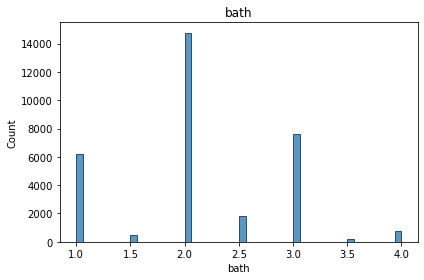

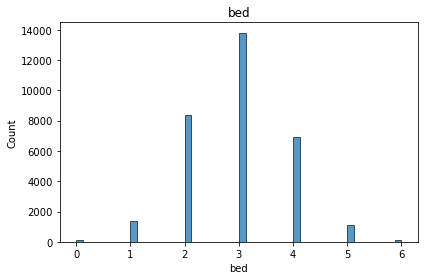

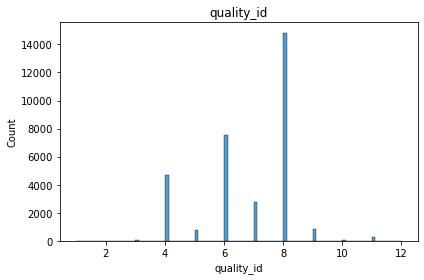

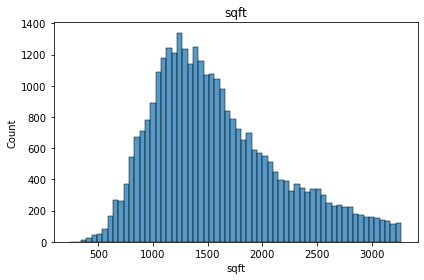

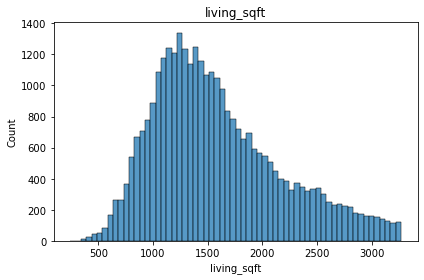

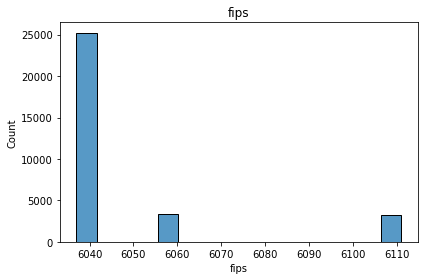

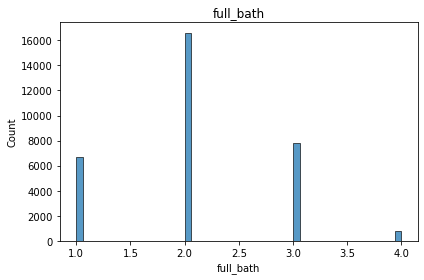

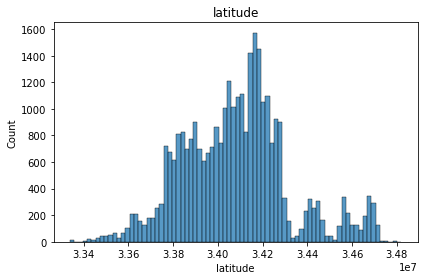

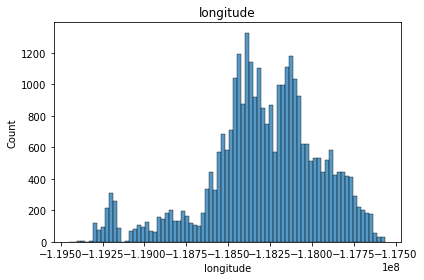

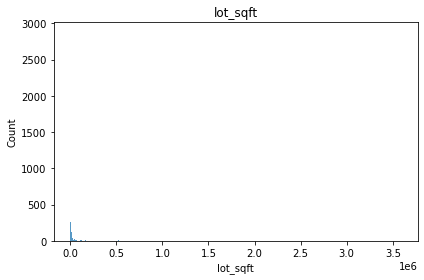

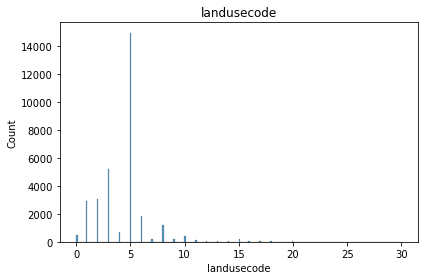

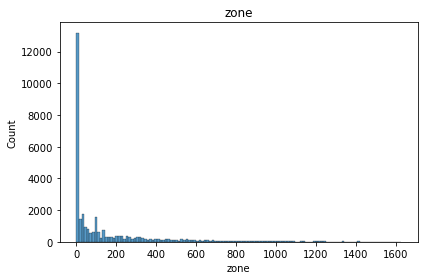

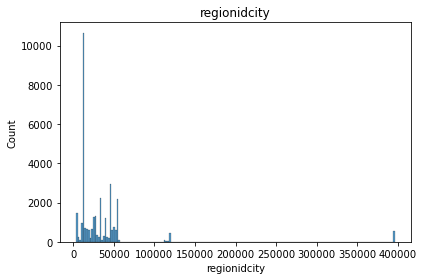

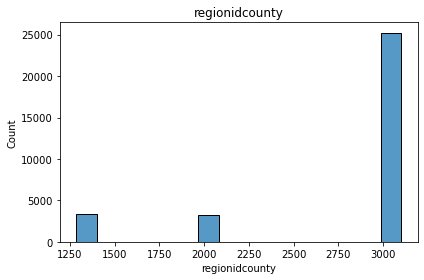

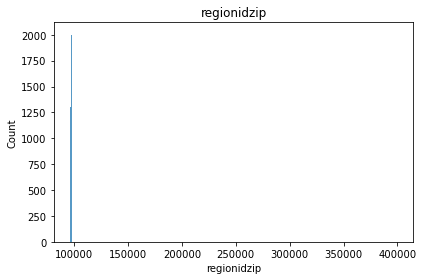

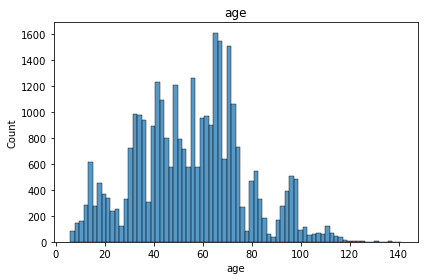

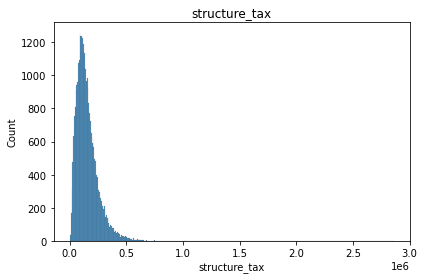

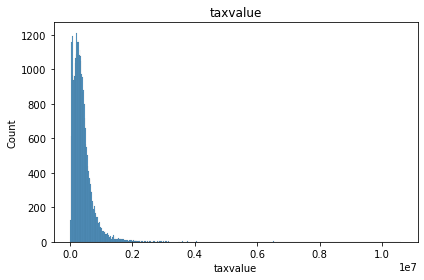

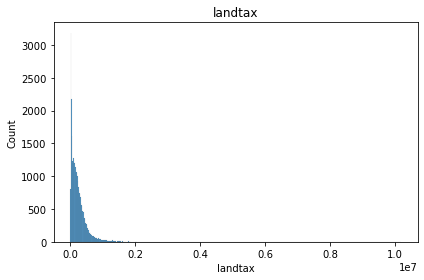

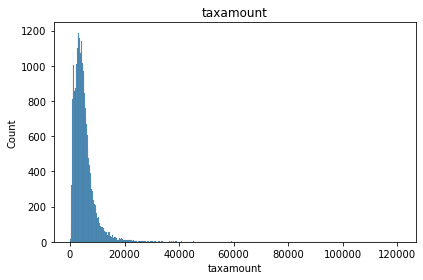

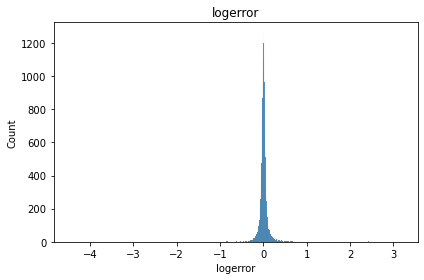

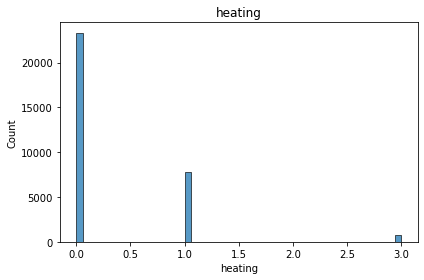

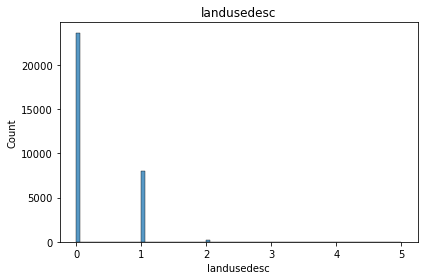

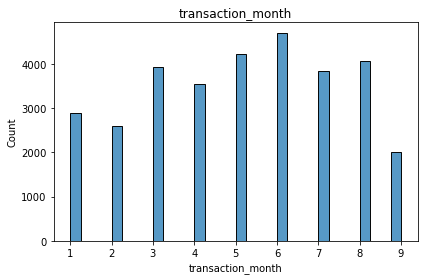

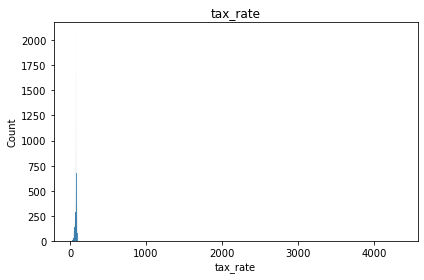

In [5]:
#Univariate Analysis
for col in train.columns:
    plt.title(col)
    sns.histplot(train[col])
    plt.tight_layout()
    plt.show()

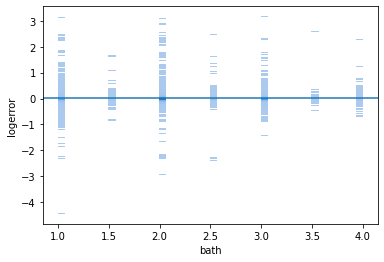

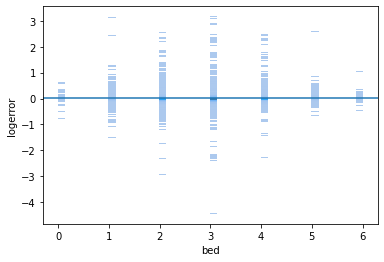

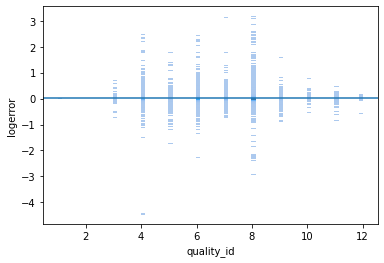

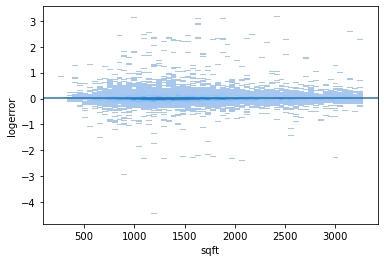

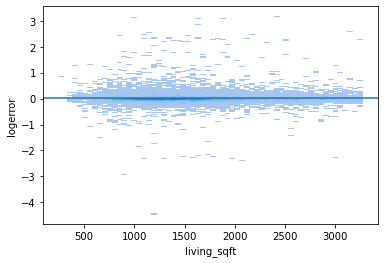

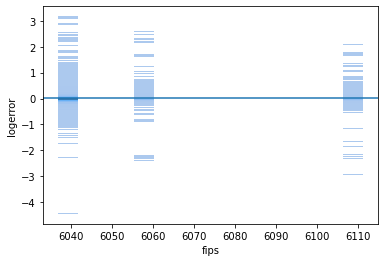

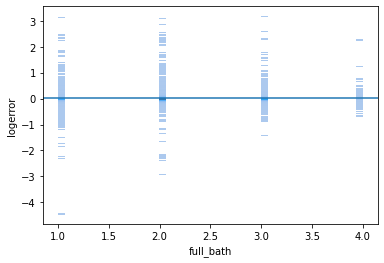

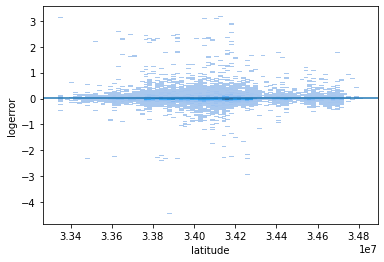

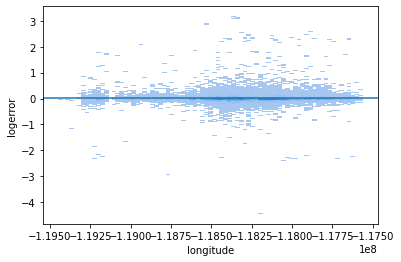

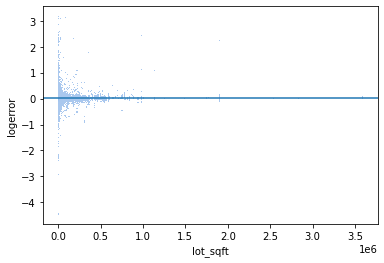

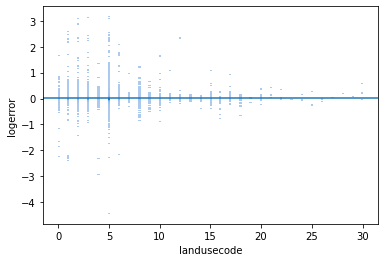

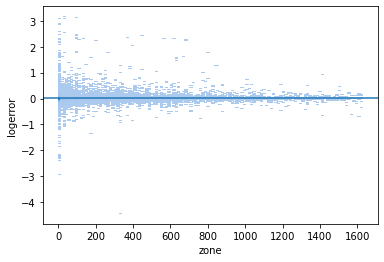

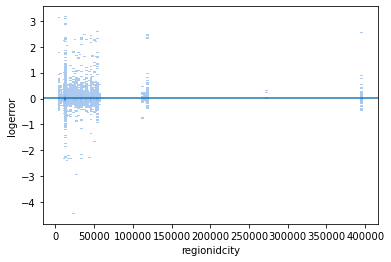

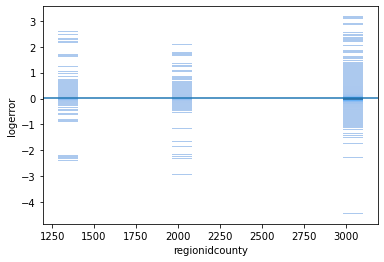

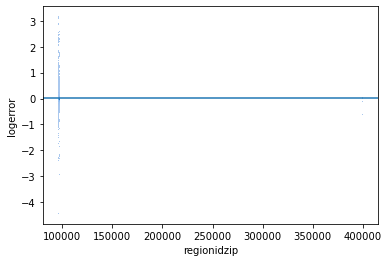

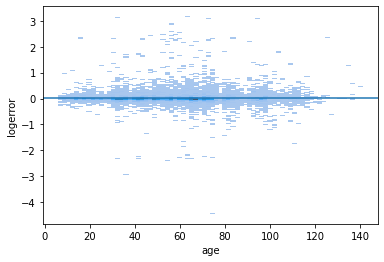

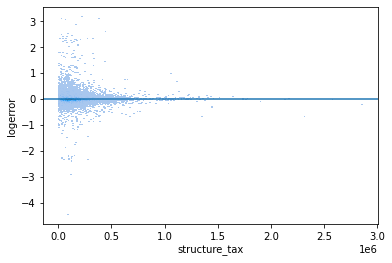

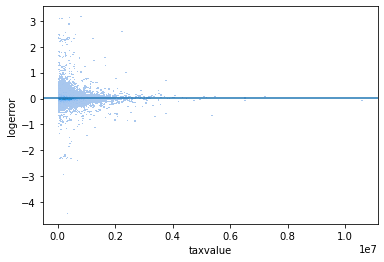

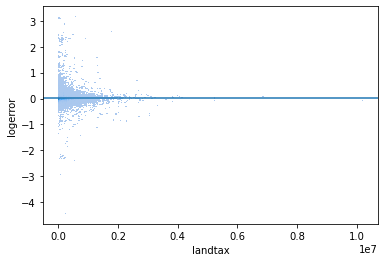

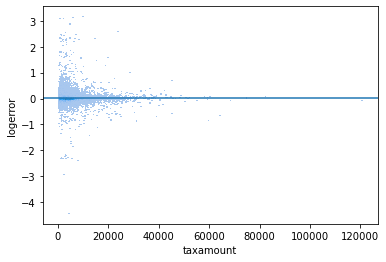

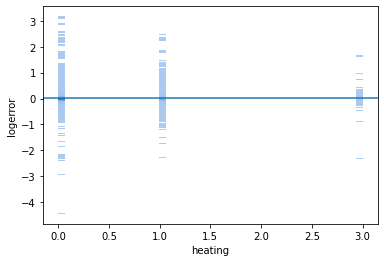

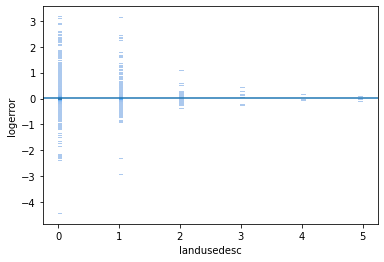

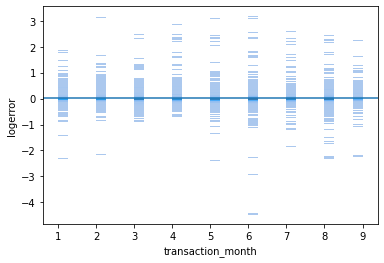

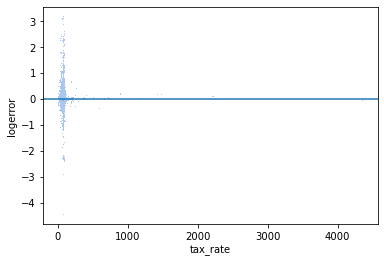

In [6]:
def plot_bivariate(df, cols, target):
    for col in df.drop(columns='logerror').columns:
        sns.histplot(data=df, x=col, y=target)
        plt.axhline(df[target].mean())
        plt.show()
plot_bivariate(train, train.columns, 'logerror')

In [91]:
# Scale the data using MinMax Scaler 
# Scale the datasets
scaler = MinMaxScaler()
cols = []
for col in train.columns:
    if train[col].dtype != 'O':
        cols.append(col)

# .copy() makes a proper copy
# this is an alternative to wrapping the scaled numpy array in a pd.Dataframe()
train_mm = train.copy()
validate_mm = validate.copy()
test_mm = test.copy()

# apply our scaler (fit only on train!)
train_mm[cols] = scaler.fit_transform(train[cols])
validate_mm[cols] = scaler.transform(validate[cols])
test_mm[cols] = scaler.transform(test[cols])

**Perpare Takeaways**
- End with 53068 rows
- Went from 68 columns to 25
- Dataset (%): 
    - Train = 60%
    - Validate = 20%
    - Test = 20%
- Univariate
    - bed count has a normal dist
    - might be able to bin age column
    - quality_id may be binned
- Bivariate
    - on average, propertiess with more than 3 bedrooms have greater logerror than properites 3 or less bedrooms
    - LA county has greater logerror variance
    - latitude/longitude have values with more negative logerror
    - lot_sqft variance =/= sqft varinace
    - landusecode >6 has greatest variance
    - zone < 200 
    - age has clusters
    - for taxamount, logerror drops after 100000

---
## Explore

Let's test some hypotheses!

<AxesSubplot:>

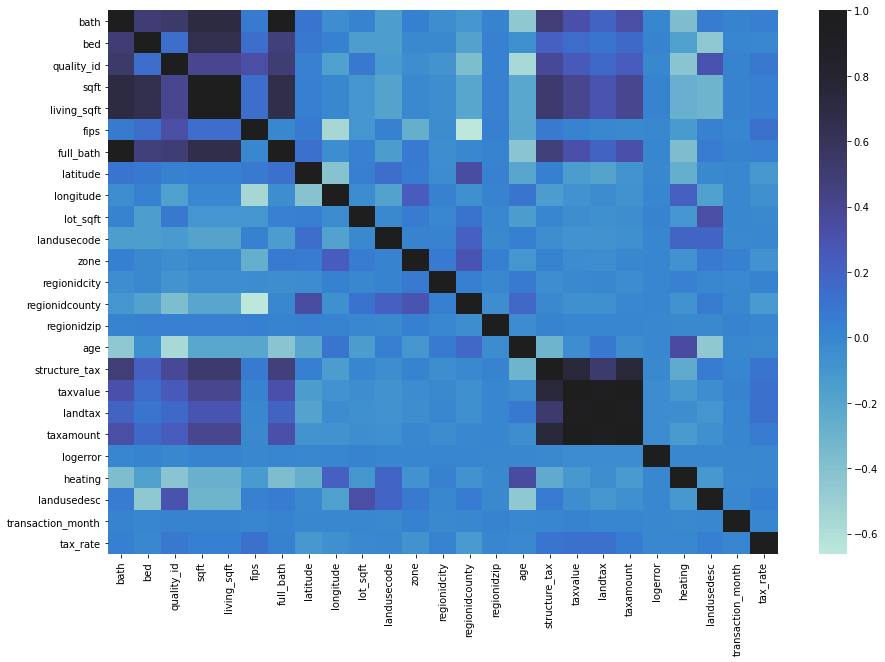

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), center=True)

### Hypothesis 1:
$H_{0}$: The mean logerror for properties with more than 3 bedrooms = mean logerror of props with 3 or less bedrooms

$H_{a}$: The mean logerror for properties with more than 3 bedrooms =/= mean logerror of props with 3 or less bedrooms

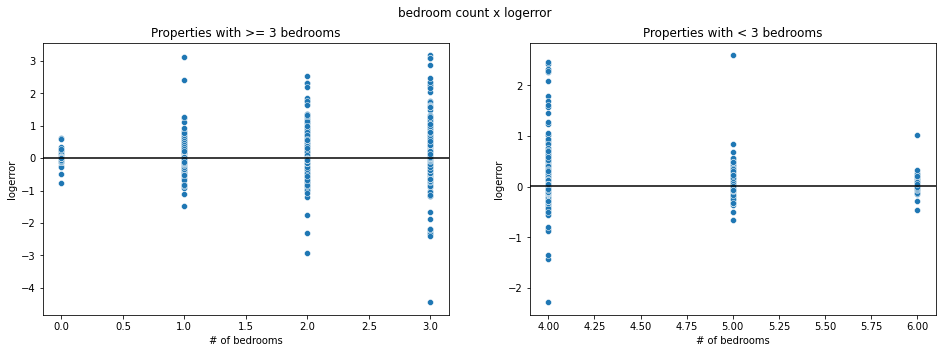

In [55]:
# Visualize bedrooms by logerror to understand potential difference in values of logerror
fig = plt.figure(figsize=(16,5))
plt.suptitle('bedroom count x logerror')

# Plot props with <= 3 bedrooms
plt.subplot(121)
ax=sns.scatterplot(data=train[train.bed <= 3], x='bed', y='logerror')
plt.axhline(train[train.bed <= 3].logerror.mean(), color='black')
plt.title('Properties with >= 3 bedrooms')
plt.xlabel("# of bedrooms")

# Plot props with > 3 bedrooms
plt.subplot(122)
ax=sns.scatterplot(data=train[train.bed > 3], x='bed', y='logerror')
plt.axhline(train[train.bed > 3].logerror.mean(), color='black')
plt.title('Potential Difference in logerror by bedroom count')
plt.title('Properties with < 3 bedrooms')
plt.xlabel("# of bedrooms")
plt.show()

In [56]:
# Set alpha
a = 0.05

# Test the subgroups for difference in logerror variance
stat, p = stats.levene(
    train[train.bed>3].logerror,
    train[train.bed<=3].logerror
)
stat, p

(20.6059187912339, 5.662775540339774e-06)

In [57]:
if p > a:
    print('The variances are equal.')
else:
    print('The variances are different.')

The variances are different.


In [59]:
# Test for similarity in average logerror for both subgroups
t, p = stats.ttest_ind(train[train.bed>3].logerror,
                       train[train.bed<=3].logerror,
                       equal_var = False)
t, p

(4.904632167858864, 9.451828339412064e-07)

In [60]:
if p > a:
    print('We reject the null hypothesis. The means are the same.')
else:
    print('We reject the null hypothesis. The mean logerror for both subgroups is significantly different.')

We reject the null hypothesis. The mean logerror for both subgroups is significantly different.


---
### Hypothesis 2:
$H_{0}$: There is no relationship between tax value and logerror.

$H_{a}$: There is a relationship between tax value and logerror.

Text(0.5, 0, '$ million')

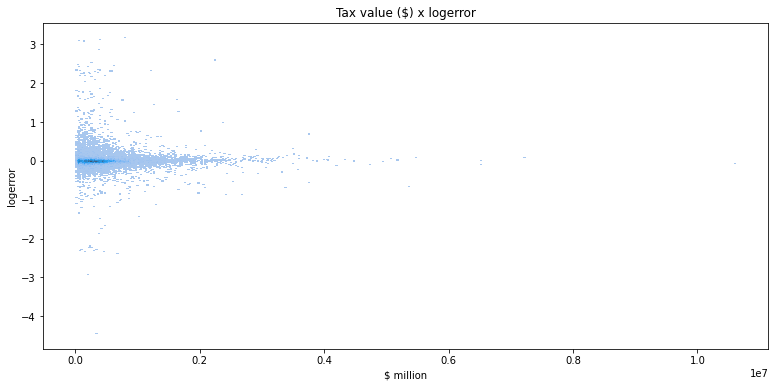

In [85]:
plt.figure(figsize=(13,6))
plt.title('Tax value ($) x logerror')
sns.histplot(x=train.taxvalue, y=train.logerror)
plt.xlabel('$ million')

In [89]:
#set alpha
a = 0.05
# Test for a linear relationship
r, p = stats.spearmanr(train.taxvalue, train.logerror)
r, p

(-0.00944912923716242, 0.09178578577106504)

In [90]:
if p > a:
    print("We accept the null hypothesis. There is no 'linear' relationship between tax value and logerror.")
else:
    print('We reject the null hypothesis. There is a relationship between tax value and logerror.')

We accept the null hypothesis. There is no 'linear' relationship between tax value and logerror.


---
### Hypothesis 3:
Look for clusters using age, sqft

In [95]:
# Create variable with features for clustering
X = train_mm[["sqft", "age"]]

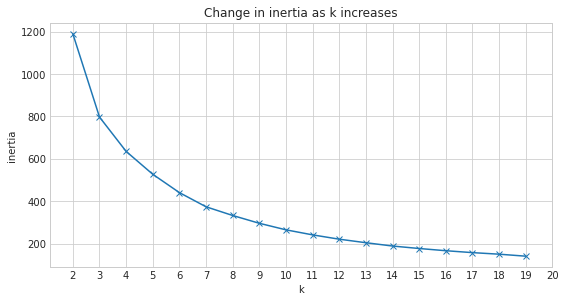

In [128]:
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 4.5))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
    plt.xticks(range(2, 21))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

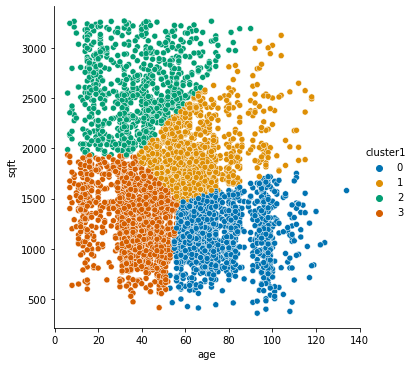

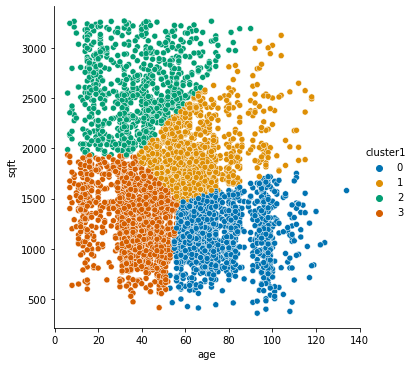

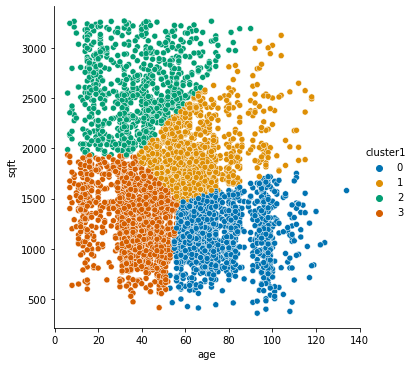

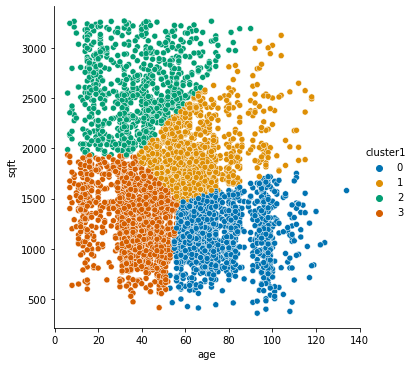

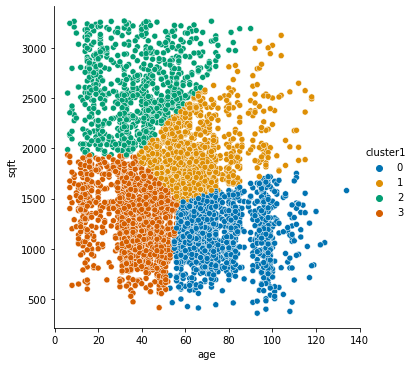

In [102]:
# Visualize potential clusters
for k in range(2,7):
    X = train_mm[["sqft", "age"]]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)

    train_mm['cluster1'] = kmeans.predict(X)
    sns.relplot(data=train.head(5_000), y="sqft", x="age", hue="cluster1", palette='colorblind')

In [129]:
kmeans = KMeans(n_clusters=5, random_state=123).fit(X)

# make a new column names cluster in iris and X_scaled dataframe
train['cluster1'] = kmeans.predict(X)
train_mm['cluster1'] = kmeans.predict(X)

# Create centroids for each cluster
centroids = train.groupby('cluster1')['age', 'sqft'].mean()
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

<AxesSubplot:xlabel='sqft', ylabel='age'>

<Figure size 720x720 with 0 Axes>

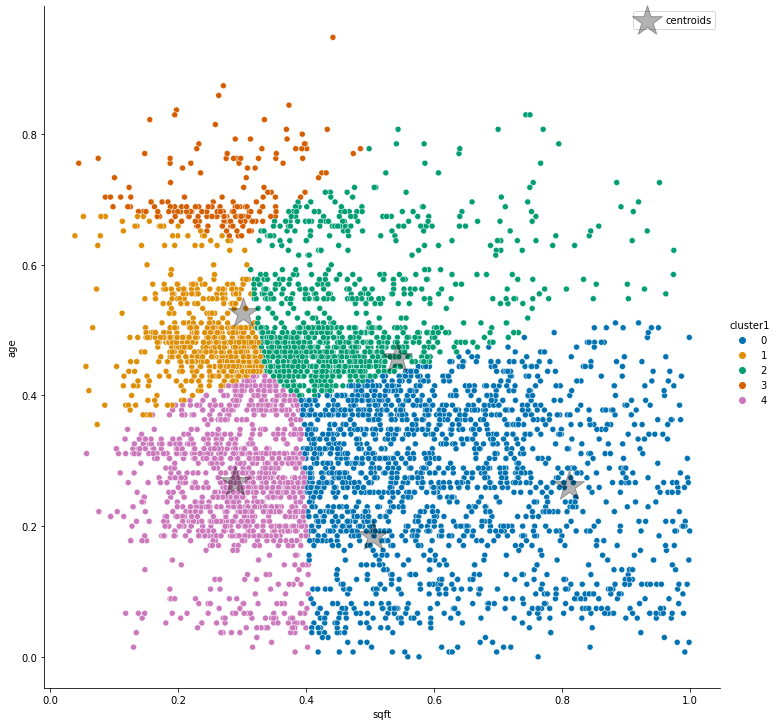

In [154]:
plt.figure(figsize=(10,10))
sns.relplot(data=train_mm.head(5_000), y="age", x="sqft", 
            hue="cluster1", 
            palette='colorblind', 
            height=10)
plt.xlabel('Square Feet')
centroids_scaled.plot.scatter(x= 'sqft', y = 'age', 
                              ax = plt.gca(), 
                              s = 1000, color = 'black', 
                              alpha = 0.3, 
                              marker='*',
                              label = 'centroids')

In [134]:
cluster1_0 = train_mm[train_mm.cluster1==0].logerror
cluster1_1 = train_mm[train_mm.cluster1==1].logerror
cluster1_2 = train_mm[train_mm.cluster1==2].logerror
cluster1_3 = train_mm[train_mm.cluster1==3].logerror
cluster1_4 = train_mm[train_mm.cluster1==4].logerror

In [135]:
train_mm['cluster1'] = kmeans.predict(train_mm[['age', 'sqft']])
validate_mm['cluster1'] = kmeans.predict(validate_mm[['age', 'sqft']])
test_mm['cluster1'] = kmeans.predict(test_mm[['age', 'sqft']])

In [138]:
# Implement ANOVA test to determine if logerror is equal across all 4 clusters

# Set alpha
a = 0.05

# Run stats test
f, p = stats.f_oneway(cluster1_0, cluster1_1,cluster1_2, cluster1_3, cluster1_4)
f, p

(3.996897485599418, 0.003040602048200711)

In [139]:
if p > a:
    print('We accept the null hypothesis. The means are the same across all 5 clusters.')
else:
    print('We reject the null hypothesis. The means are different across all 5 clusters.')

We reject the null hypothesis. The means are different across all 5 clusters.


---
### Hypothesis 4:
Look for clusters using latitude, longitude, heating

**NOTE: heating only specifices central (0), floor/wall:(1), and other (3)**

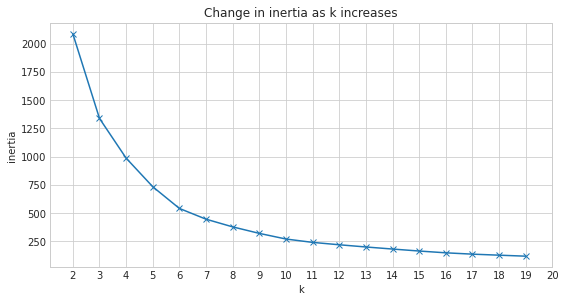

In [142]:
X = train_mm[['latitude', 'longitude', 'heating']]
# lets plot inertia vs k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 4.5))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
    plt.xticks(range(2, 21))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

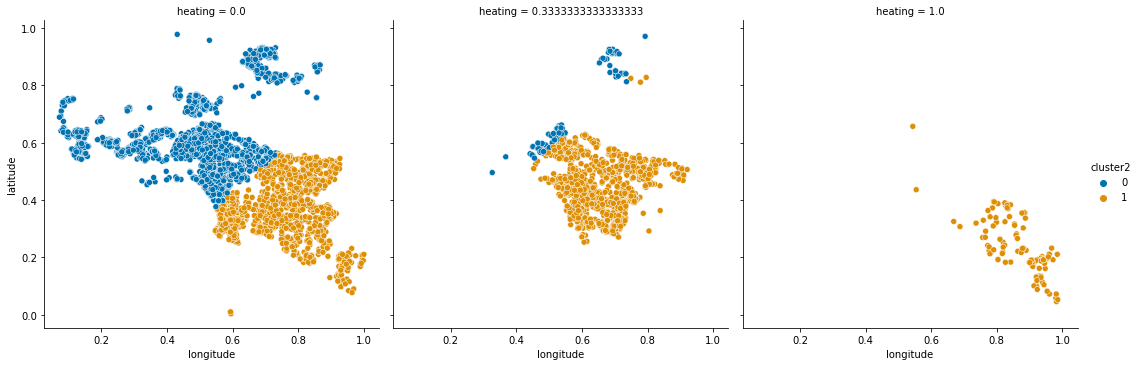

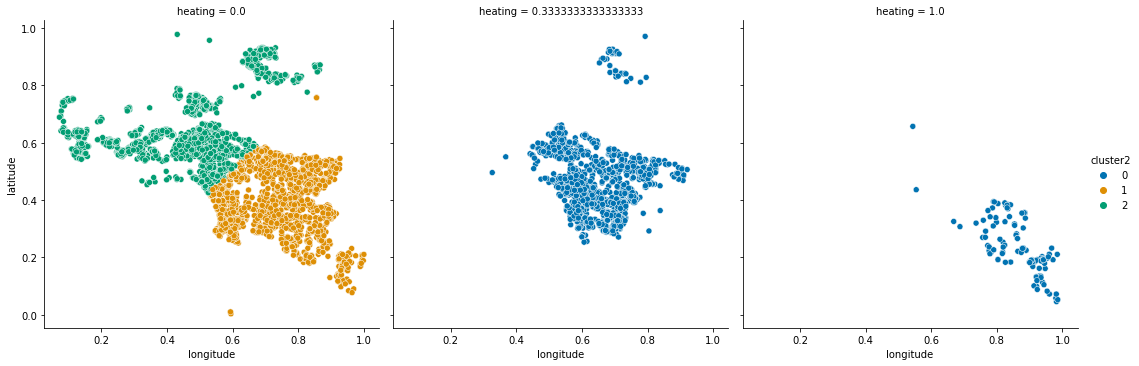

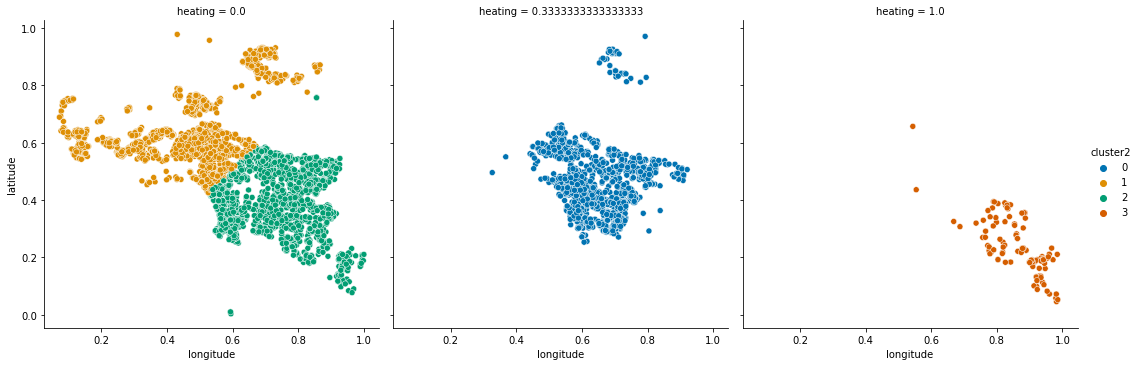

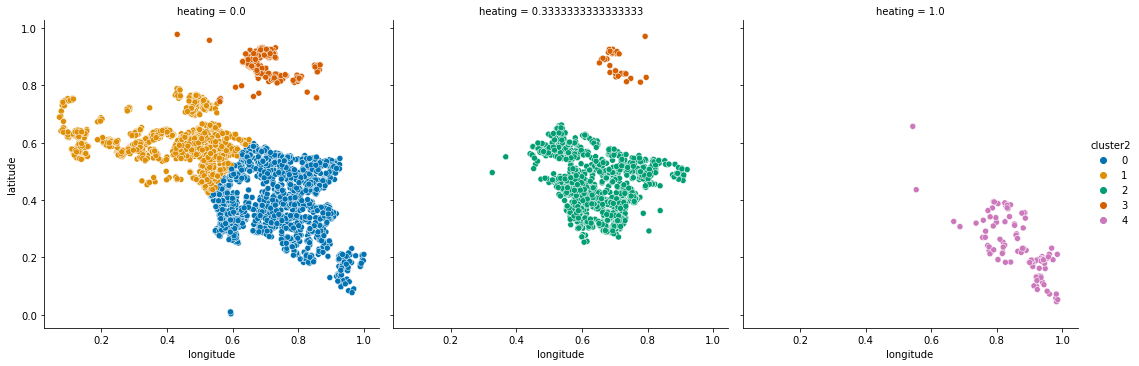

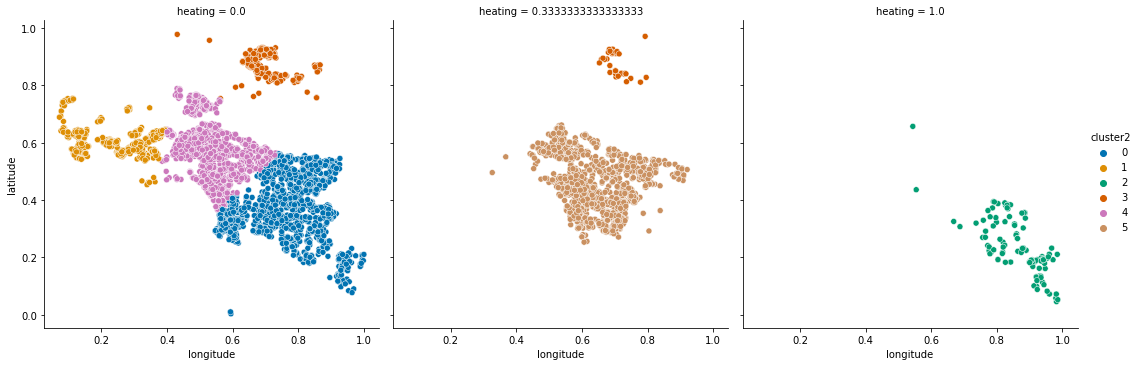

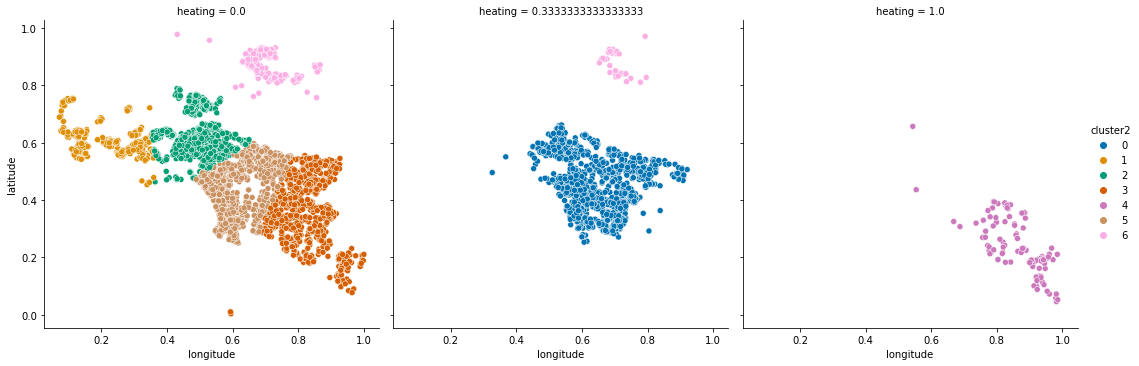

In [143]:
for k in range(2,8):
    X = train_mm[['latitude', 'longitude', 'heating']]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)

    train_mm['cluster2'] = kmeans.predict(X)
    sns.relplot(data=train_mm.head(5_000), y="latitude", x="longitude", col='heating', hue='cluster2', palette='colorblind')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 720x720 with 0 Axes>

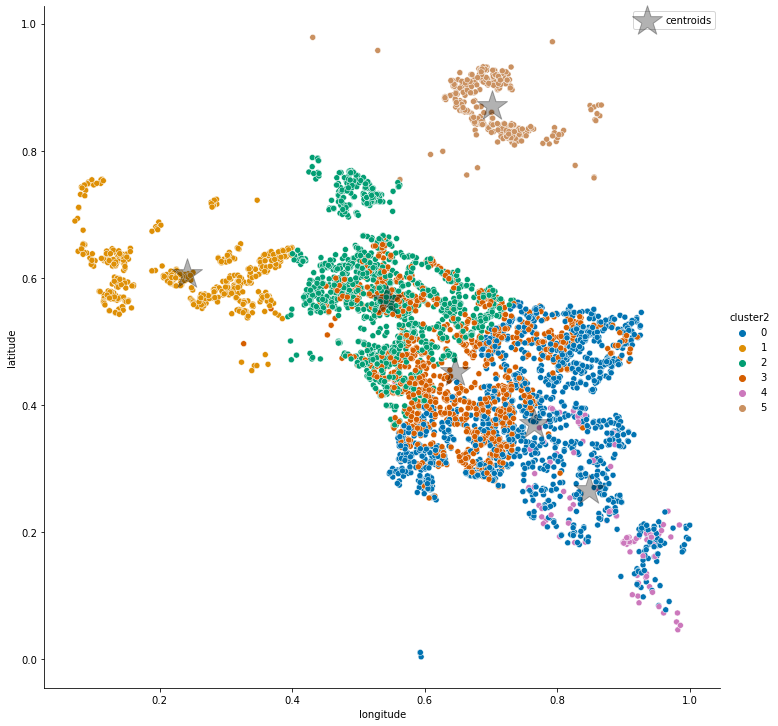

In [149]:
# Indicate number of clusters
# fit the object
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

# Create prediction columns in training dataset
train_mm['cluster2'] = kmeans.predict(X)
train['cluster2'] = kmeans.predict(X)

# Create centroids
centroids2 = train.groupby('cluster2')['latitude', 'longitude', 'heating'].mean()
centroids_scaled2 = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

# Plot
plt.figure(figsize=(10,10))
sns.relplot(data=train_mm.head(5_000), y="latitude", x="longitude",
            hue='cluster2', 
            palette='colorblind',
            height=10)
centroids_scaled2.plot.scatter(x= 'longitude', y = 'latitude', 
                              ax = plt.gca(), 
                              s = 1000, color = 'black', 
                              alpha = 0.3, 
                              marker='*',
                              label = 'centroids')

In [155]:
cluster2_0 = train_mm[train_mm.cluster2==0].logerror
cluster2_1 = train_mm[train_mm.cluster2==1].logerror
cluster2_2 = train_mm[train_mm.cluster2==2].logerror
cluster2_3 = train_mm[train_mm.cluster2==3].logerror
cluster2_4 = train_mm[train_mm.cluster2==4].logerror
cluster2_5 = train_mm[train_mm.cluster2==5].logerror



train_mm['cluster2'] = kmeans.predict(train_mm[['latitude', 'longitude', 'heating']])
validate_mm['cluster2'] = kmeans.predict(validate_mm[['latitude', 'longitude', 'heating']])
test_mm['cluster2'] = kmeans.predict(test_mm[['latitude', 'longitude', 'heating']])

# run ANOVA test to determine if logerror is equal across all clusters
# Set alpha
a = 0.05

# Run stats test
f, p = stats.f_oneway(cluster2_0, cluster2_1, cluster2_2, cluster2_3, cluster2_4, cluster2_5)
f, p

(3.231951915732137, 0.0064113897586916295)

In [156]:
if p > a:
    print('We accept the null hypothesis. The means are the same across all 6 clusters.')
else:
    print('We reject the null hypothesis. The means are different across all 6 clusters.')

We reject the null hypothesis. The means are different across all 6 clusters.


---
### Hypothesis 5:
Look for clusters using tax rate, bath, fips

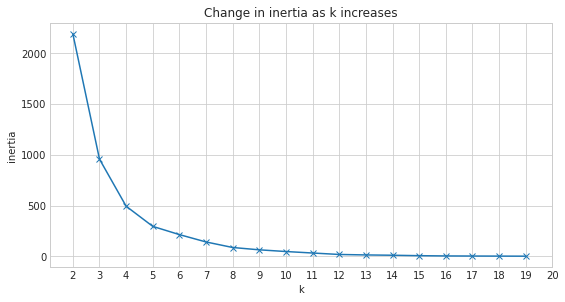

In [198]:
# lets plot inertia vs k
X = train_mm[['bath', 'tax_rate', 'fips']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 4.5))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
    plt.xticks(range(2, 21))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

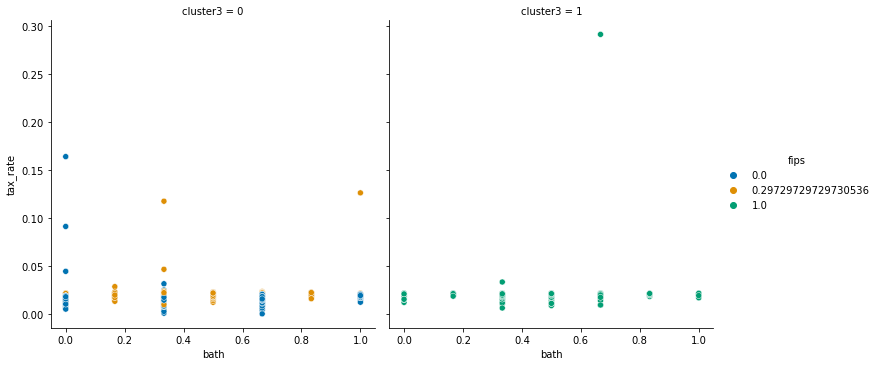

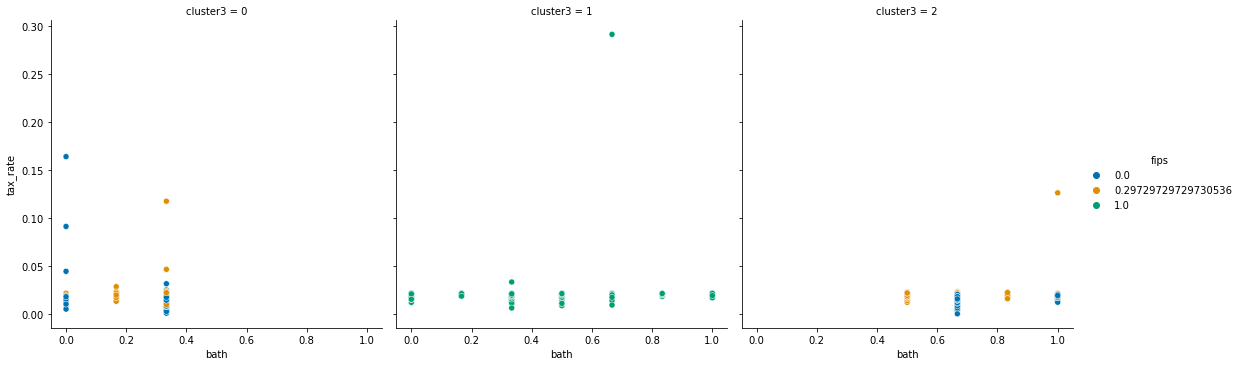

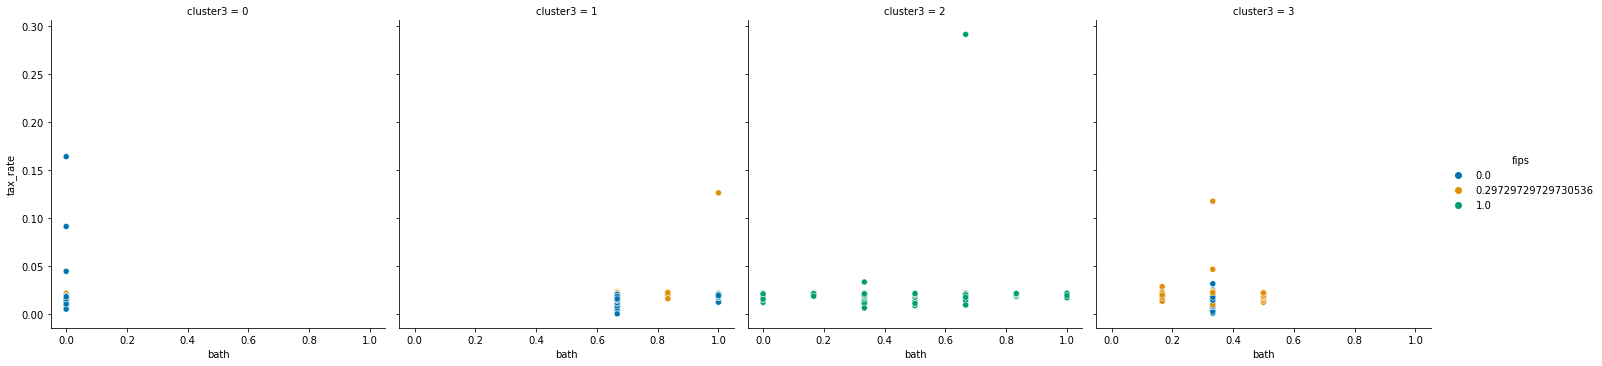

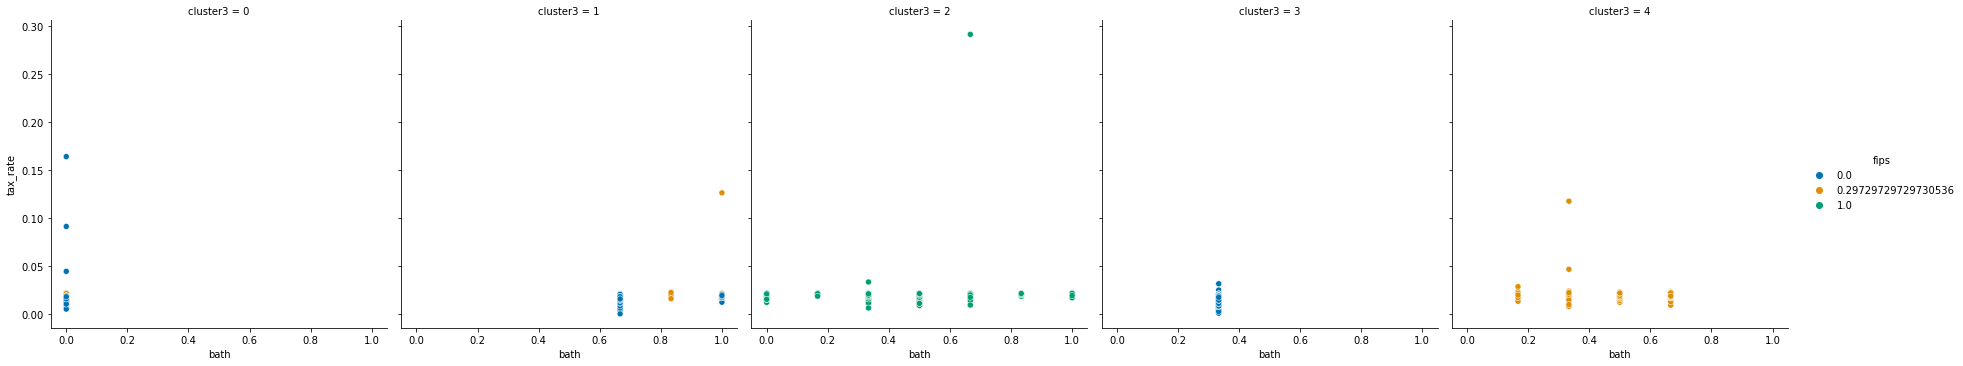

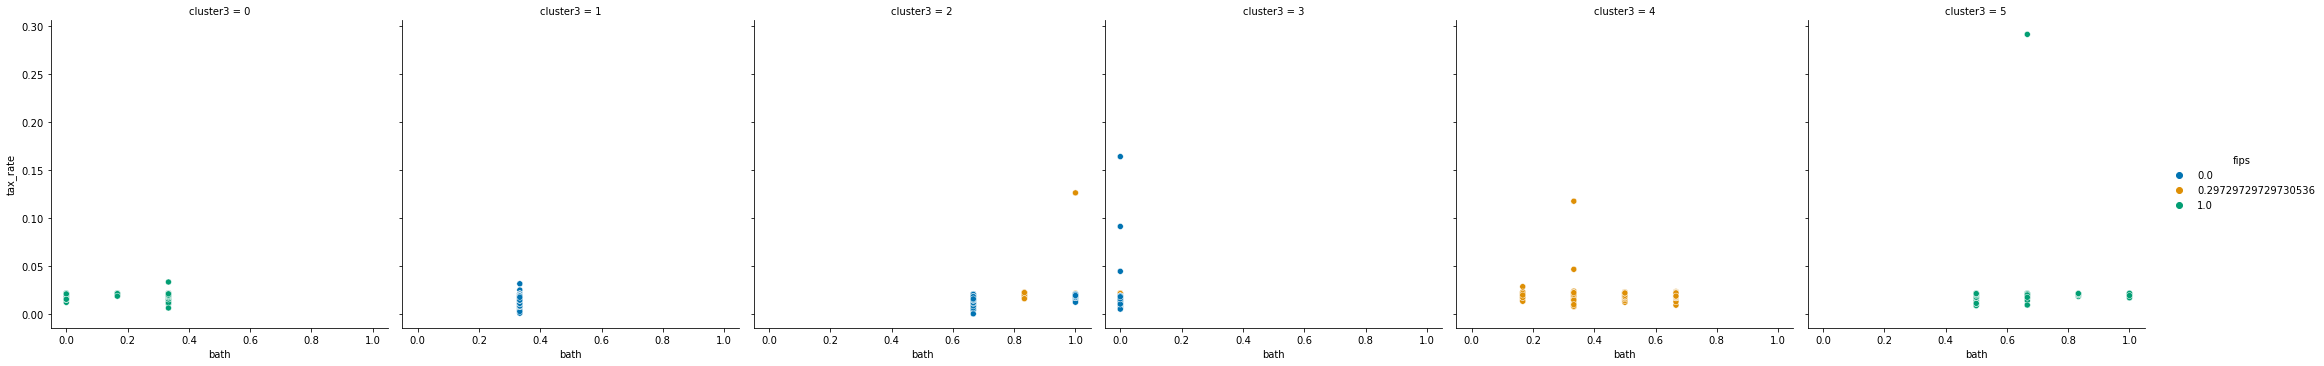

In [199]:
for k in range(2,7):
    X = train_mm[['bath', 'tax_rate', 'fips']]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)

    train_mm['cluster3'] = kmeans.predict(X)
    sns.relplot(data=train_mm.head(5_000), y="tax_rate", x="bath", hue='fips', col='cluster3', palette='colorblind')

<AxesSubplot:xlabel='bath', ylabel='tax_rate'>

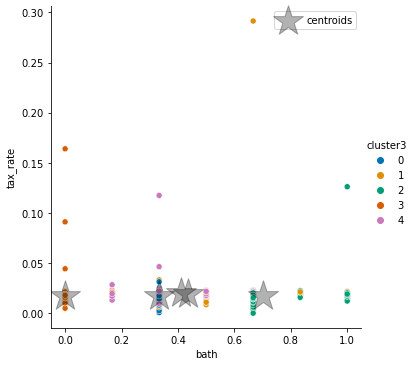

In [218]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

train_mm['cluster3'] = kmeans.predict(X)
train['cluster3'] = kmeans.predict(X)
centroids3 = train.groupby('cluster3')['bath', 'tax_rate', 'fips'].mean()
centroids_scaled3 = pd.DataFrame(kmeans.cluster_centers_, columns = X.columns)

sns.relplot(data=train_mm.head(5_000), y="tax_rate", x="bath", hue='cluster3', palette='colorblind')
centroids_scaled3.plot.scatter(x= 'bath', y = 'tax_rate', 
                              ax = plt.gca(), 
                              s = 1000, color = 'black', 
                              alpha = 0.3, 
                              marker='*',
                              label = 'centroids')

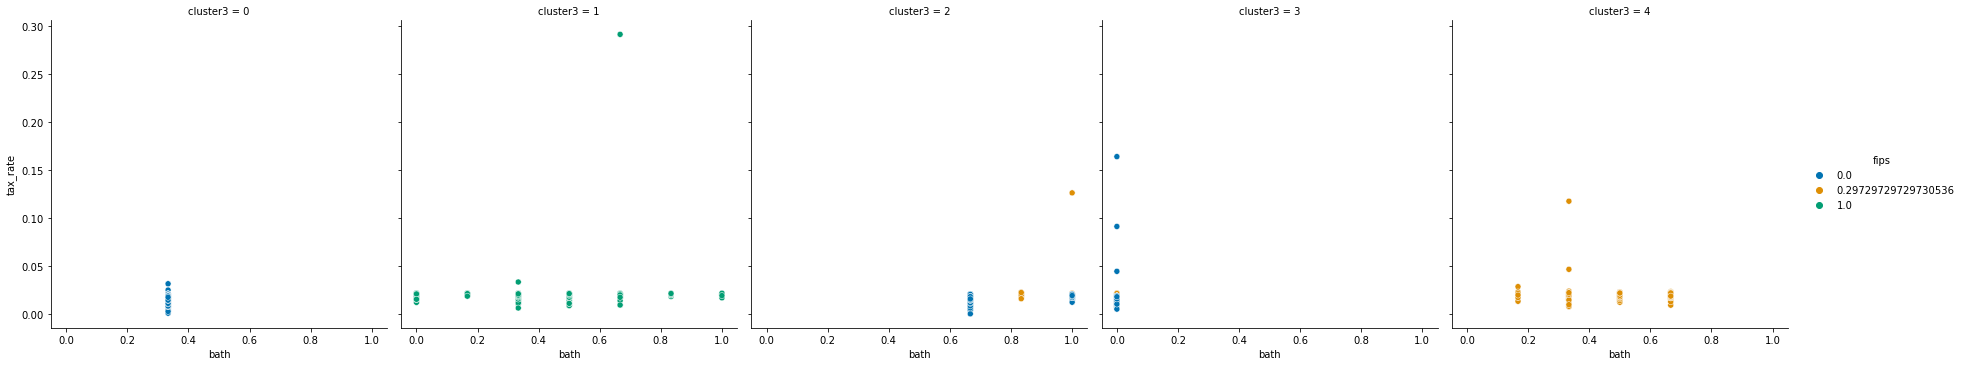

In [219]:
sns.relplot(data=train_mm.head(5_000), y="tax_rate", x="bath", hue='fips', col='cluster3', palette='colorblind')

In [220]:
cluster3_0 = train_mm[train_mm.cluster3==0].logerror
cluster3_1 = train_mm[train_mm.cluster3==1].logerror
cluster3_2 = train_mm[train_mm.cluster3==2].logerror
cluster3_3 = train_mm[train_mm.cluster3==3].logerror
cluster3_4 = train_mm[train_mm.cluster3==4].logerror


train_mm['cluster3'] = kmeans.predict(train_mm[['bath', 'tax_rate', 'fips']])
validate_mm['cluster3'] = kmeans.predict(validate_mm[['bath', 'tax_rate', 'fips']])
test_mm['cluster3'] = kmeans.predict(test_mm[['bath', 'tax_rate', 'fips']])

In [221]:
# run ANOVA test to determine if logerror is equal across all clusters

# Set alpha
a = 0.05

f, p = stats.f_oneway(cluster3_0, cluster3_1, cluster3_2, cluster3_3, cluster3_4)
f, p

(0.4119912789590842, 0.800145024796428)

In [222]:
if p > a:
    print('We accept the null hypothesis. The means are the same across all 5 clusters.')
else:
    print('We reject the null hypothesis. The means are different across all 5 clusters.')

We accept the null hypothesis. The means are the same across all 5 clusters.


**Explore Takeaways**
- Mean logerror for properties with more than 3 bedrooms is different from the mean logerror of properties with 3 bedrooms or less.
- There is no linear relationship with tax value and logerror.
- When identifing 5 clusters using square feet and age of property, the mean logerror is different across all 5 clusters.
- When identifing 6 clusters using latitude, longitude, and heating system of property, the mean logerror is different across all 6 clusters.
- When identifing 5 clusters using bathroom count, tax rate, and county of property, the mean logerror is the same across all 6 clusters.

# Model